In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import math
import scipy
import scipy.linalg
import geostatspy.GSLIB as GSLIB          # GSLIB utilities, viz and wrapped functions
import geostatspy.geostats as geostats    # GSLIB converted to Python
from scipy.stats import norm

In [2]:
os.chdir('C:\\Users\\jjs4476\\Documents\\Research')
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

In [3]:
def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var

def GSLIB_sgsim_2d_uncond(nreal, nx, ny, hsiz, seed,hrange1,hrange2,azi,output_file):
    """
    Sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory).
    Sequential Gaussian simulation (SGS) simulates continuous variables, such as petrophysical properties.
    """
    hmn = hsiz * 0.5  
    hctab = int(hrange1/hsiz)*2 + 1
    sim_array = np.random.rand(nx,ny)
    
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()
    os.system('"sgsim.exe sgsim.par"')      
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)        
    return(sim_array)

def GSLIB2ndarray(data_file,kcol,nx,ny):
    """
    Utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
    """
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)   
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]      
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name

def affine(array,tmean,tstdev):
    '''
    Affine distribution correction reimplemented in Python with numpy methods. It takes the current distribution and shifts
    it according to the target distribution: streching, squeezing, shifting the distribution. No shape changes.
    '''
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)

    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy] = (tstdev/stdev)*(array[ix,iy] - mean) + tmean 
    return(array)

def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    """
    Pixel plot, reimplemention in Python of GSLIB pixelplt with matplotlib methods.
    """
    print(str(step))
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.tif',dpi=600)
    plt.show()
    return im

def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    """
    Pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods (version for subplots)
    """
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# n' effective
def n_effec(nreal, sample_init, sample_final, vario_range):
    """
    Code to evaluate that evaluates the number of effective data in the set.
    nreal: Number of realizations (just need a sufficient number to summarize uncertainty)
    sample_init: Smallest data set of samples
    sample_final: Largest data set of samples
    vario_range: range of variogram
    """
    s = 0
    for itera in np.arange(sample_init, sample_final):

    # 1. Make Spatial Dataset

        # Assign Data Values - assume 7 data locations
        ndata = itera                                            # User Specified
        output = np.zeros((ndata, nreal))                        # x, y, value; 7x10000.
                                                                 # "output" contains the bootstrap sampling from "value"
        data = sim1.copy()

        # Set up backtransform lookup table
        np.random.seed(42)
        value = np.zeros(ndata) 
        for i in np.arange(0, ndata):
            value[i] = data[np.random.randint(0, 100), np.random.randint(0, 100)]

        value.sort()

        # 2. Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified, var_range
        cov = np.zeros((ndata, ndata))
        var_range = vario_range                                          # User Specified
        for i in range(0, ndata):
            for j in range(0, ndata):
                distance = math.sqrt(math.pow((data[i,0]-data[j,0]),2) + math.pow((data[i,1]-data[j,1]),2))
                cova = 0.0
                if(distance < var_range):
                    hr = distance / var_range
                    cova = 1.0 - hr * (1.5 - 0.5* hr * hr)  # spherical structure, no nugget
                    cov[i,j] = cova

        # 3. Perform LU Decomposition using scipy (used tutorial at www.quantstart.com) 
        # Compute pivoted LU decompostion of a matrix.
        # A = P L U, where P is a permutation matrix, L lower triangular with unit diagonal elements, and U upper triangular.
        P, L, U = scipy.linalg.lu(cov)

        rand = np.zeros(ndata) 
        pvalue = np.zeros(ndata) # Percentile for backtransform

        """
        # 4. Calculate Unconditional Realization at the Specified Locations from the Data Distribution with Replacement
            Realizations in Gaussian space are converted to p-values and then applied to draw from the original distribution
            """
        # np.random.seed(11) # remove the # symbol to avoit reproducibility; but be aware of the range of itera
        for ireal in range(0, nreal):    
            for i in range(0, ndata):
                rand[i] = np.random.normal()
            realization = np.matmul(L,rand)
        # Convert to p-values    
            for i in range(0, ndata):
                pvalue[i] = norm.cdf(realization[i])
        # Complete backtransform by selecting percentiles from original cdf (drawing with replacement from provided data values)       
                index = int(round(ndata * pvalue[i] - 0.5))
                output[i, ireal] = value[index]

        """
        # 5. Calculate the summary statistic of interest (mean only for this example). 
        Any summary statistic may be calculated.
        """
        summary = np.zeros(nreal) # summary vector stores all the statistics at each bootstrap
        for ireal in range(0, nreal): 
            mean = 0
            for i in range(0, ndata):
                mean += output[i, ireal]    
            mean /= ndata
            summary[ireal] = mean

        # 7. Summary statistics to describe uncertainty in the mean from bootstrap
        summary = pd.DataFrame(summary, columns=[itera])
        variance = pd.Series(value.var(), index=[itera])
        if s == 0:
            df_mean = summary
            df_var = variance
        else:
            df_mean = pd.concat([df_mean, summary], axis=1)
            df_var = pd.concat([df_var, variance])

        s += 1

    n_eff = df_var / df_mean.var(axis=0)
    return n_eff, value, output

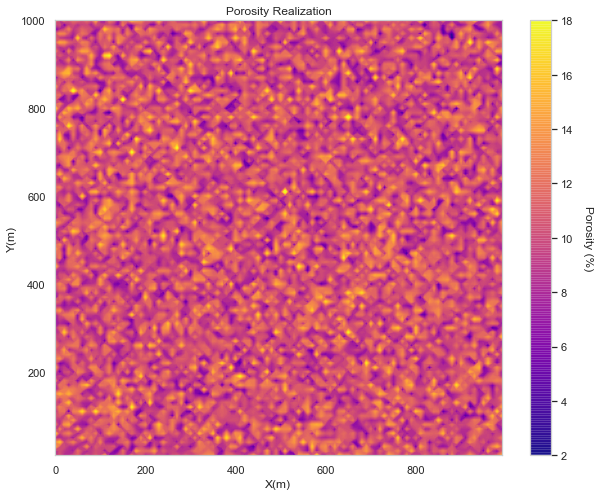

In [4]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 41                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 90                    # Porosity variogram ranges and azimuth
mean = 10.0; stdev = 2.5                                         # Porosity mean and standard deviation
vmin = 2; vmax = 18; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# Calculate a stochastic realization with standard normal distribution
vario = make_variogram(0.0, nst=1, it1=1, cc1=1.0, azi1=0, hmaj1=1, hmin1=1)
#vario = make_variogram(0.0, nst=1, it1=1, cc1=1.0, azi1=65, hmaj1=1800, hmin1=500)
# def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):

# hmaj1 and hmin1 are the variogram ranges in major and minor directions respectively
                       
sim1, value = GSLIB_sgsim_2d_uncond(1, nx, ny, cell_size, seed, vario['hmaj1'], vario['hmin1'], azimuth, "simulation")
sim1 = affine(sim1, mean, stdev)              # correct the distribution to a target mean and standard deviation.

plt.figure(figsize=(10, 8))
                       
pixelplt_st(sim1 , xmin, xmax, ymin, ymax, cell_size, vmin, vmax, "Porosity Realization", "X(m)",
            "Y(m)", "Porosity (%)",cmap);

In [9]:
n_prime, value, outp = n_effec(1000, 5, 40, 1)

In [10]:
n_prime

5      5.370024
6      6.100484
7      7.337684
8      7.841735
9      8.448799
10     9.925704
11    10.629974
12    12.845767
13    12.623764
14    14.183185
15    14.768566
16    14.577294
17    15.448752
18    16.954088
19    17.633075
20    19.522360
21    19.577930
22    19.112408
23    20.078280
24    22.865749
25    23.026418
26    25.133384
27    23.413712
28    25.126833
29    25.333247
30    24.950793
31    28.533768
32    27.530695
33    28.766371
34    28.898085
35    29.711943
36    29.702466
37    30.594376
38    30.878245
39    31.490078
dtype: float64